In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib

from pcap_processor import calculate_features



In [2]:
# Check if CUDA (NVIDIA's GPU programming toolkit) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Using device: cuda


In [3]:
# Load the tensors from the .pt files
data_tensors = torch.load('data_tensors_7.5s_0.01s_large.pt')
target_tensors = torch.tensor(torch.load('target_tensors_7.5s_0.01s_large.pt'))

print("Data tensors and target tensors loaded successfully!")

# Example usage: Checking the shapes of the loaded tensors
print(f"Number of data samples: {len(data_tensors)}")
print(f"Shape of first data sample: {data_tensors[0].shape}")
print(f"Shape of target tensor: {target_tensors.shape}")

Data tensors and target tensors loaded successfully!
Number of data samples: 22000
Shape of first data sample: torch.Size([750, 22])
Shape of target tensor: torch.Size([22000])


In [4]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out


# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]



In [5]:
# Normalize the target tensors
target_mean = target_tensors.mean()
target_std = target_tensors.std()

# Make a function to denormalize a prediction
def denormalize(tensor):
    return tensor * target_std + target_mean

target_tensors = (target_tensors - target_mean) / target_std

train_data, test_data, train_targets, test_targets = train_test_split(
    data_tensors, target_tensors, test_size=0.2, random_state=42
)

# Create datasets and data loaders
train_dataset = PacketCaptureDataset(train_data, train_targets)
test_dataset = PacketCaptureDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
input_size = len(train_dataset[0][0][0])  # Assuming all packet captures have the same structure
hidden_size = 128
output_size = 1
model = RNNModel(input_size, hidden_size, output_size).to(device)  # Move model to GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
# FILEPATH: /home/ziv/Desktop/coding/speedtest-research/cs293n/model/lstm.ipynb
# model.load_state_dict(torch.load('model_weights_7.5s_0.01s_large.pt'))

# num_epochs = 5_000

# model.train()
# with tqdm(total=num_epochs) as pbar:
#     prev_loss = float('inf')
#     for epoch in range(num_epochs):
#         total_loss = 0
#         num_batches = 0
#         for inputs, targets in train_loader:
#             inputs, targets = inputs.to(device).float(), targets.to(device).float()  # Move data to GPU
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs.squeeze(), targets)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#             num_batches += 1
#         average_loss = total_loss / num_batches
#         pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
#         pbar.update(1)

#         prev_loss = average_loss


In [8]:
model.load_state_dict(torch.load('large_models_128/large_epoch_240.pt'))

<All keys matched successfully>

In [9]:
# save the weights of the model to a file
# torch.save(model.state_dict(), 'model_weights_7.5s_0.01s_large.pt')

In [10]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to calculate total absolute error
total_absolute_error = 0
num_samples = len(test_targets)

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value
        predicted_value = model(input_tensor).item()
        actual_value = target_value.item()

        # Calculate absolute error
        absolute_error = abs(predicted_value - actual_value)
        total_absolute_error += absolute_error

# Calculate average absolute error
average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error: {average_absolute_error}")


Average Absolute Error: 0.18235667527921445


In [11]:
# Initialize variables to calculate total absolute error for denormalized values
total_absolute_error = 0
num_samples = len(test_targets)

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value and denormalize it
        predicted_value = denormalize(model(input_tensor).item())
        actual_value = denormalize(target_value.item())

        # Calculate absolute error
        absolute_error = abs(predicted_value - actual_value)
        total_absolute_error += absolute_error

# Calculate average absolute error
average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error (Denormalized): {average_absolute_error}")


Average Absolute Error (Denormalized): 22.322341893602015


In [12]:
# Initialize list to store absolute errors
absolute_errors = []

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value
        predicted_value = model(input_tensor).item()
        actual_value = target_value.item()

        # Calculate absolute error and append to list
        absolute_error = abs(predicted_value - actual_value)
        absolute_errors.append(absolute_error)

# Calculate median absolute error
median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

Median Absolute Error: 0.018694470110929045


In [13]:
# get the median absolute error for the denormalized values
absolute_errors = []

for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error (Denormalized): {median_absolute_error}")


Median Absolute Error (Denormalized): 2.2883963677059267


In [14]:
# get the mean square error
total_square_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0).to(device)).item()
    actual_value = test_targets[i].to(device).item()
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error: {mean_square_error}")


Mean Square Error: 0.934156387681756


In [15]:
# get the mean square error for the denormalized values
total_square_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error (Denormalized): {mean_square_error}")


Mean Square Error (Denormalized): 13997.670555370847


In [16]:
# print each actual vs prediction value
for i in range(num_samples):
    predicted_value = model(test_data[i].to(device).unsqueeze(0)).item()
    actual_value = test_targets[i].to(device).item()
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: -0.1394786305512086, Predicted: -0.15570640563964844
Actual: -0.17687911356746014, Predicted: 0.1969059705734253
Actual: -0.2394562478238186, Predicted: -0.23991334438323975
Actual: -0.24209244457235315, Predicted: -0.2520754337310791
Actual: -0.23980181063487968, Predicted: -0.24740099906921387
Actual: -0.1776333139621485, Predicted: -0.18727779388427734
Actual: -0.2344773569277506, Predicted: -0.20297181606292725
Actual: -0.012552556382376918, Predicted: 0.27919042110443115
Actual: 0.01843331789774625, Predicted: -0.06116437911987305
Actual: -0.2466782284790561, Predicted: -0.24839162826538086
Actual: -0.1911216469912455, Predicted: -0.22135257720947266
Actual: 0.06967101784482298, Predicted: -0.09160518646240234
Actual: -0.2334169240389776, Predicted: -0.25760340690612793
Actual: -0.24552852487705656, Predicted: -0.2511845827102661
Actual: -0.2212805224292376, Predicted: -0.24213576316833496
Actual: -0.18541681170754679, Predicted: -0.17177176475524902
Actual: -0.19870292113

In [17]:
# print each actual vs prediction value for denormalized values
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: 13.305834013192012, Predicted: 11.319386612009751
Actual: 8.727628320440026, Predicted: 54.4827860636165
Actual: 1.0675402899170656, Predicted: 1.0115869464918
Actual: 0.7448425601548365, Predicted: -0.47717849709463067
Actual: 1.0252398301044003, Predicted: 0.0950206204956281
Actual: 8.635306396711457, Predicted: 7.454722368854483
Actual: 1.6770079974347674, Predicted: 5.533611840703017
Actual: 28.84289739993771, Predicted: 64.55525330106707
Actual: 32.63588868196247, Predicted: 22.892307844846965
Actual: 0.18349521129105284, Predicted: -0.02624263226309509
Actual: 6.98419501847836, Predicted: 3.2836166927349346
Actual: 38.90791274858468, Predicted: 19.16603838979804
Actual: 1.8068159436597533, Predicted: -1.153859550876522
Actual: 0.3242308155174598, Predicted: -0.36812912430691114
Actual: 3.292436942594243, Predicted: 0.7395399162654606
Actual: 7.682525822406561, Predicted: 9.352820604635252
Actual: 6.056168702877464, Predicted: 8.512820859532585
Actual: 2.239926942174826, P

In [18]:
# Calculate the average percentage error of the model
total_percentage_error = 0
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error: {average_percentage_error}%")

# Print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors: {percentage_errors_std}")

# Remove the max 2 percent of the errors and calculate the average percentage error
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%): {average_percentage_error * 100}%")

# Print the standard deviation of the percentage errors (without top 2%)
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%): {percentage_errors_std}")


Average Percentage Error: 158.83599379713684%
Standard Deviation of Percentage Errors: 25.313454153009623
Average Percentage Error (Without Top 2%): 32.455204900157426%
Standard Deviation of Percentage Errors (Without Top 2%): 25.567826314532603


In [19]:
# Calculate the average percentage error of the model for denormalized values
total_percentage_error = 0
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error (Denormalized): {average_percentage_error}%")

# Print the standard deviation of the percentage errors for denormalized values
percentage_errors = []  
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Denormalized): {percentage_errors_std}")

# Remove the max 2 percent of the errors and calculate the average percentage error for denormalized values
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%, Denormalized): {average_percentage_error * 100}%")

# Print the standard deviation of the percentage errors for denormalized values (without top 2%)
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): {percentage_errors_std}")


Average Percentage Error (Denormalized): 414.0643617289724%
Standard Deviation of Percentage Errors (Denormalized): 112.94802598721728
Average Percentage Error (Without Top 2%, Denormalized): 32.455204900157426%
Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): 114.09345038609223


In [20]:
# Calculate the median percentage error of the model
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error: {median_percentage_error}%")


Median Percentage Error: 8.992047623593427%


In [21]:
# Calculate the median percentage error of the model for denormalized values
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error (Denormalized): {median_percentage_error}%")


Median Percentage Error (Denormalized): 73.08366838940351%


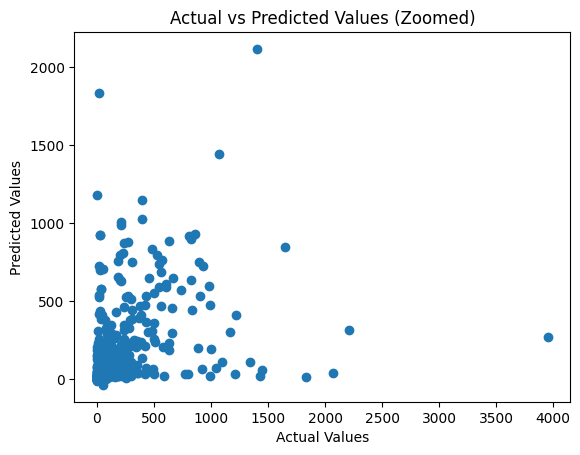

In [22]:
# Plot the denormalized values for the actual and predicted values on the testing set

import matplotlib.pyplot as plt

actual_values = []
predicted_values = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)

plt.scatter(actual_values, predicted_values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Zoomed)")
# plt.xlim(0, 25)
# plt.ylim(0, 25)
plt.show()


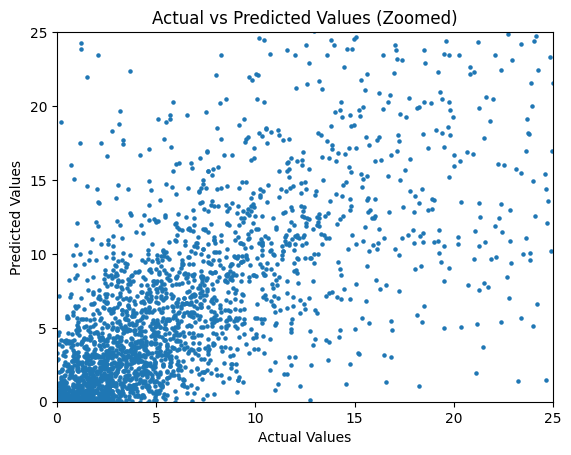

In [23]:
# Plot the denormalized values for the actual and predicted values on the testing set

import matplotlib.pyplot as plt

actual_values = []
predicted_values = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)

plt.scatter(actual_values, predicted_values, s=5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Zoomed)")
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.show()
